In [ ]:
import os
import re
import csv
import numpy as np
import pandas as pd
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM, Dense, Dropout, multiply, Flatten

In [ ]:
# Loading the pre-processed data from 
combined_data = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/Deepak Dissertation/pickles/combined_data_CP1_Big.pkl")

In [ ]:
combined_data.head()

,question1,question2,isDuplicate,q1len,q2len
20955,Regex too much or none at all. regex example s...,My regex is matching too much. How do I make i...,1,308,360
22107,Browser Mode options missing from IE11's F12 D...,"How to bring back ""Browser mode"" in IE11? cros...",1,260,396
27053,NSData in base 10 ios objective-c c possible n...,Printing NSData using NSLog iphone objective-c...,1,127,347
22483,JSF View Scoped Bean Reconstructed Multiple Ti...,@ViewScoped calls @PostConstruct on every post...,1,380,279
3808,"a ""+"" sign in email address iphone objective-c...",Team Foundation services are not available fro...,0,362,437


In [ ]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 20955 to 215115
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question1    40000 non-null  object
 1   question2    40000 non-null  object
 2   isDuplicate  40000 non-null  int64 
 3   q1len        40000 non-null  int64 
 4   q2len        40000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.8+ MB


In [ ]:
MAX_WORDS = 200000

tokenizer = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(list(combined_data['question1'].values.astype(str)) + list(combined_data['question2'].values.astype(str)))

In [ ]:
X_train_q1 = tokenizer.texts_to_sequences(combined_data['question1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen=30, padding='post')


X_train_q2 = tokenizer.texts_to_sequences(combined_data['question2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen=30, padding='post')

In [ ]:
X_train_q1

array([[  271,  1793,   371, ...,   710, 15395,   657],
       [28331,   722,  2365, ...,   585,  1263,   116],
       [ 2949,     3,   218, ...,     0,     0,     0],
       ...,
       [  130,    33,   372, ...,     0,     0,     0],
       [    5,    86,   200, ...,     0,     0,     0],
       [    7,     6,  5757, ...,     0,     0,     0]], dtype=int32)

In [ ]:
y = combined_data['isDuplicate']

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/unzipped/glove.6B.200d.txt.zip','r') as zip_ref:
  zip_ref.extractall('/content/drive/MyDrive/unzipped/')

In [ ]:
#Loading Glove word embedding

glove_file = open('/content/drive/MyDrive/unzipped/glove.6B.200d.txt','r',encoding='utf-8')

In [ ]:
embeddings_index = {}

for line in tqdm(glove_file):
  values = line.split(" ")
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')

  embeddings_index[word] = coefs

glove_file.close()

400000it [00:14, 28096.39it/s]


In [ ]:
list(embeddings_index.items())[0]

('the', array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
         3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
         1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
        -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
         4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
         7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
         1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
        -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
        -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
         6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
        -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
         8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
         1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
         1.4379e-01, -1.2325e-01, -5.8178e-0

In [ ]:
len(tokenizer.word_index)

139939

In [ ]:
#Creating embdding matrix for the words that we have in our training dataset 

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))

for word, index in tqdm(tokenizer.word_index.items()):
  embedding_vector = embeddings_index.get(word)

  # if the word is present in the embedding_index of the glove later
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

100%|██████████| 139939/139939 [00:00<00:00, 528757.95it/s]


In [ ]:
from sklearn.model_selection import train_test_split

X_train_q1,X_valid_q1,X_train_q2, X_valid_q2, y_train, y_valid = train_test_split(X_train_q1, X_train_q2, y, test_size=0.20, random_state=12)

In [ ]:
print(X_train_q1.shape, X_train_q2.shape, y_train.shape)
print(X_valid_q1.shape, X_valid_q2.shape, y_valid.shape)

(254820, 30) (254820, 30) (254820,)
(63706, 30) (63706, 30) (63706,)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Model for the Q1

model_q1 = Sequential([Embedding(input_dim = vocab_size, output_dim = 200, weights = [embedding_matrix],input_length=30),
                       LSTM(128,activation='tanh',return_sequences=True),
                       Dropout(0.2),
                       LSTM(128,return_sequences=True),
                       LSTM(128),
                       Dense(60, activation='tanh'),
                       Dense(2, activation='sigmoid')
                       ])

In [ ]:
# Model for Q2

model_q2 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [ ]:
#Merging the output of the two models

mergedOut = multiply([model_q1.output, model_q2.output])

In [ ]:
mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(1, activation = 'sigmoid')(mergedOut)


In [ ]:
new_model_glove = tf.keras.Model([model_q1.input, model_q2.input], mergedOut)

new_model_glove.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history_glove = new_model_glove.fit([X_train_q1,X_train_q2],y_train, 
                        batch_size = 2000, epochs = 15)

Epoch 1/15
128/128 [==============================] - 637s 5s/step - loss: 0.6177 - accuracy: 0.6544
Epoch 2/15
128/128 [==============================] - 635s 5s/step - loss: 0.5294 - accuracy: 0.7374
Epoch 3/15
128/128 [==============================] - 648s 5s/step - loss: 0.4750 - accuracy: 0.7758
Epoch 4/15
128/128 [==============================] - 658s 5s/step - loss: 0.4190 - accuracy: 0.8096
Epoch 5/15
128/128 [==============================] - 645s 5s/step - loss: 0.3666 - accuracy: 0.8367
Epoch 6/15
128/128 [==============================] - 636s 5s/step - loss: 0.3232 - accuracy: 0.8575
Epoch 7/15
128/128 [==============================] - 653s 5s/step - loss: 0.2869 - accuracy: 0.8749
Epoch 8/15
128/128 [==============================] - 649s 5s/step - loss: 0.2565 - accuracy: 0.8898
Epoch 9/15
128/128 [==============================] - 646s 5s/step - loss: 0.2327 - accuracy: 0.9012
Epoch 10/15
128/128 [==============================] - 645s 5s/step - loss: 0.2113 - accura

In [ ]:
y_pred = new_model_glove.predict([X_valid_q1, X_valid_q2], batch_size=2000, verbose=1)
y_pred += new_model_glove.predict([X_valid_q1, X_valid_q2], batch_size=2000, verbose=1)

32/32 [==============================] - 53s 2s/step


In [ ]:
y_pred /= 2

In [ ]:
y_pred[0]

array([0.9996623], dtype=float32)

In [ ]:
y_pred = (y_pred > 0.5).astype(np.float32)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix


def print_metrics(y_test,y_pred,modeltype='Model'):
  print("The accuracy score for duplicate question detection using "+modeltype+" is %f\n" %accuracy_score(y_test,y_pred))
  print("The precision score for duplicate question detection using "+modeltype+" is %f\n" %precision_score(y_test,y_pred))
  print("The recall score for duplicate question detection using "+modeltype+" is %f\n" %recall_score(y_test,y_pred))
  print("The f1 score for duplicate question detection using "+modeltype+" is %f\n" %f1_score(y_test,y_pred))
  cf_matrix = confusion_matrix(y_test,y_pred)
  print(cf_matrix)
  sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')

The accuracy score for duplicate question detection using LSTM with Glove is 0.735849

The precision score for duplicate question detection using LSTM with Glove is 0.711245

The recall score for duplicate question detection using LSTM with Glove is 0.796368

The f1 score for duplicate question detection using LSTM with Glove is 0.751403

[[21446 10325]
 [ 6503 25432]]


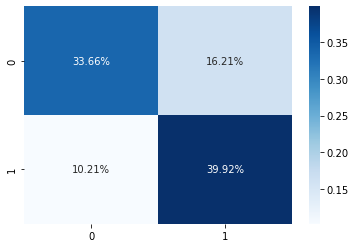

In [ ]:
print_metrics(y_valid.to_numpy(),y_pred,'LSTM with Glove')

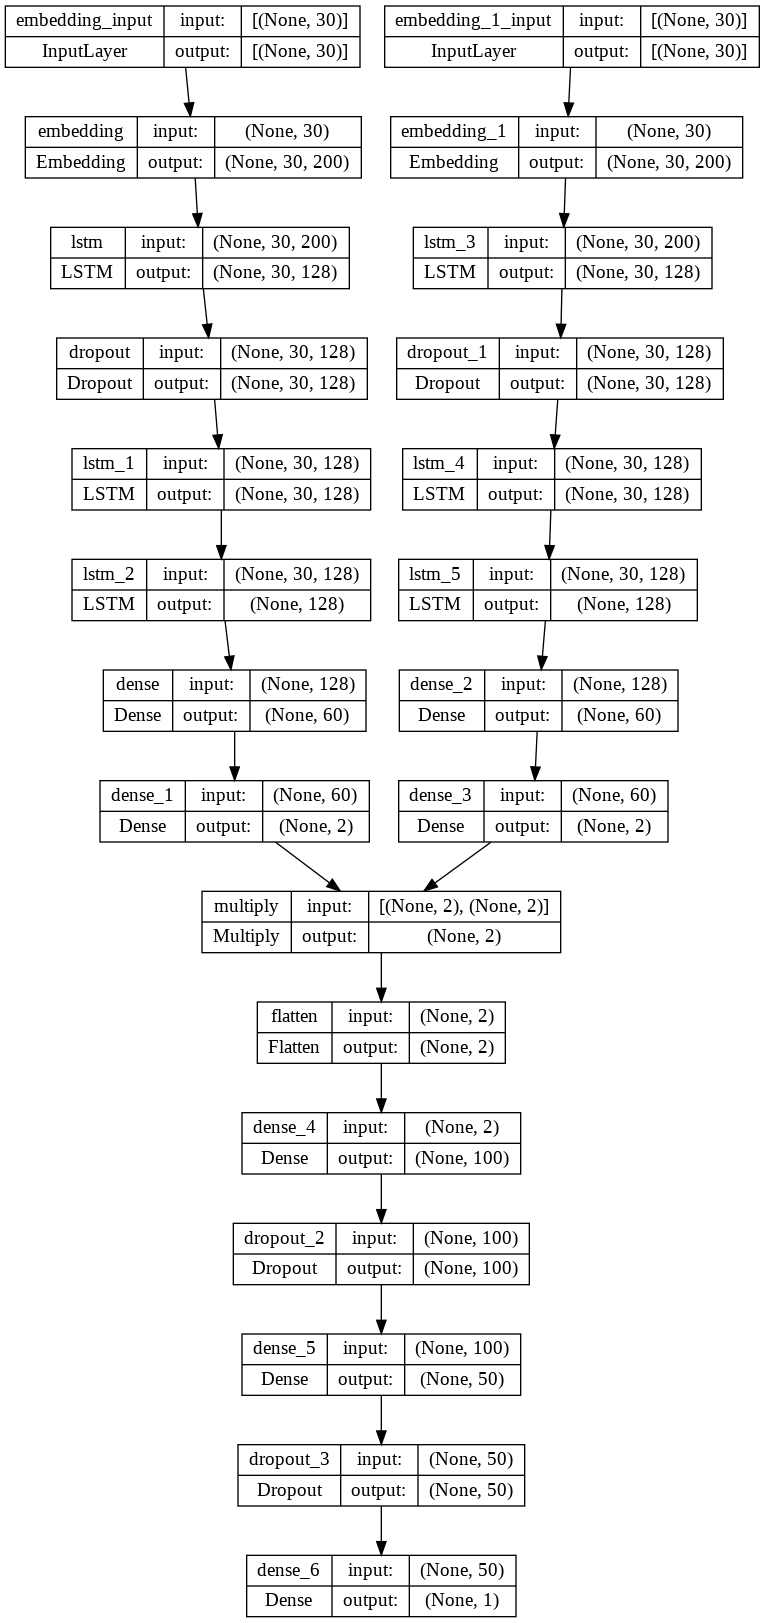

In [ ]:
from keras.utils.vis_utils import plot_model


plot_model(new_model_glove,show_layer_names=True,show_shapes=True)

In [ ]:
history_glove.history.keys()

In [ ]:
def plot_acc_loss_curves(history):
  acc = history.history['accuracy']
  loss = history.history['loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.title('Training accuracy and loss')
  plt.legend()

  plt.show()

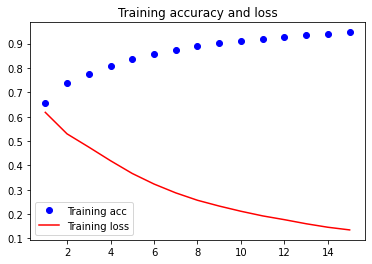

In [ ]:
plot_acc_loss_curves(history=history_glove)

In [ ]:
# Modification starts from here in order to change it to word2vec embedding

def build_corpus(data):
    "Creates a list of lists containing words from each sentence - as word2vec only supports the input to be list of lists"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

In [ ]:
corpus = build_corpus(combined_data)

In [ ]:
## Creating the word2Vec model
from gensim.models import word2vec

word2vec_model = word2vec.Word2Vec(corpus, size=200, window=20, min_count=200, workers=4)

In [ ]:
word2vec_model.train(corpus,epochs=10,total_examples=len(corpus))

(48727300, 82161320)

In [ ]:
# embedding of a particular word.
word2vec_model.wv.get_vector('play')

array([-1.6661412 , -1.4736875 ,  1.041721  , -1.7642025 ,  1.5849365 ,
       -0.8638434 , -0.03218809,  1.0636398 ,  0.2541314 ,  1.0483611 ,
        0.13396741,  2.4767303 ,  0.9363006 , -1.3045919 ,  1.2646425 ,
        3.647457  ,  3.427061  ,  0.6142606 ,  0.00800931,  0.18736953,
       -0.08342563, -0.1801598 ,  1.660177  , -1.6430933 ,  0.31246504,
       -0.5502294 , -1.1904477 , -0.4214448 ,  1.1281136 , -1.4035602 ,
        2.926488  , -0.09762037,  1.187703  ,  0.62127125, -2.0857317 ,
        1.9493186 ,  1.0594959 , -0.19473018, -0.9199101 , -0.7957995 ,
        0.66303426, -2.2675552 ,  0.05339527,  2.1865575 ,  0.39711735,
       -1.8482145 ,  1.1829628 ,  0.07839173,  1.0033203 ,  2.2598195 ,
        2.252415  ,  2.2404208 , -1.3418697 , -0.17897564,  2.920449  ,
       -1.7692946 , -0.22041446, -0.7801243 ,  1.0352584 ,  0.66589415,
       -1.3541274 , -2.5947027 ,  0.9546444 ,  2.1662862 , -1.3617665 ,
        2.1650841 , -2.5397077 ,  1.9801517 ,  0.39964673,  0.03

In [ ]:
# total numberof extracted words.
vocab=word2vec_model.wv.vocab
print("The total number of words are : ",len(vocab))

The total number of words are :  3550


In [ ]:
# words most similar to a given word.
word2vec_model.wv.most_similar('play')

[('sound', 0.4382355809211731),
 ('playing', 0.4304750859737396),
 ('player', 0.4174354672431946),
 ('music', 0.41359883546829224),
 ('audio', 0.4130435585975647),
 ('played', 0.39681705832481384),
 ('guitar', 0.37220513820648193),
 ('video', 0.3701932430267334),
 ('start', 0.36623334884643555),
 ('listen', 0.354325532913208)]

In [ ]:
# similaraity b/w two words
word2vec_model.wv.similarity('good','like')

0.24015914

In [ ]:
print("The no of words :",len(vocab))
# print(vocab)

The no of words : 3550


In [ ]:
word_vec_dict={}

for word in vocab:
  word_vec_dict[word]=word2vec_model.wv.get_vector(word)

In [ ]:
# now creating the embedding matrix
embed_matrix=np.zeros((len(tokenizer.word_index)+1, 200))
for word,i in tqdm(tokenizer.word_index.items()):
  embed_vector = word_vec_dict.get(word)

  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.

100%|██████████| 139939/139939 [00:00<00:00, 1254226.63it/s]


In [ ]:
# checking.
print(embed_matrix[14])

[ 1.24578345  0.11594974 -0.09019105  0.16318893 -0.94260812  0.37687671
 -0.02378231  0.56035423 -0.33055642 -1.2840873   0.29892734  0.20919423
  0.14376801  1.64699447  2.10312009 -0.94365668 -1.0470891   0.59723818
  1.73147452  1.44384742 -0.24695659 -0.03811959  0.3045437   0.21856719
 -0.20002024  1.60999489 -0.70332062 -0.36361194 -1.56010652  0.13519238
  0.49697763  1.27125728  0.95948339 -0.67942971 -1.79215837  0.46474802
 -0.54387367  0.04004367  0.18052498  1.23572659  1.51795816 -0.76962411
 -0.90063572 -0.91287512 -1.2217859   0.61339206 -1.39309812  0.76815999
 -0.75145364 -0.0505941  -0.76508534  0.40422514  0.62515986 -0.86846435
  0.48406476  0.71234328  0.05905409 -0.20806672 -1.53122783  0.05780181
 -1.52571738  0.52016318 -4.31319571 -1.29350829  0.33205307  0.50199002
 -0.06961012 -0.80711091  0.88651687  0.89342827  1.93407035 -1.03229535
 -0.92978191 -0.08856789 -0.2331453  -1.21733153  0.50302094  0.22577955
 -1.70775247 -0.65074456  0.85838407  0.8312844   0

In [ ]:
# Model for the Q1 - Using Word2Vec

model_q1 = Sequential([Embedding(input_dim = vocab_size, output_dim = 200, weights = [embed_matrix],input_length=30),
                       LSTM(128,activation='tanh',return_sequences=True),
                       Dropout(0.2),
                       LSTM(128,return_sequences=True),
                       LSTM(128),
                       Dense(60, activation='tanh'),
                       Dense(2, activation='sigmoid')
                       ])

In [ ]:
# Model for Q2 - Using Word2Vec

model_q2 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embed_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [ ]:
#Merging the output of the two models

mergedOut = multiply([model_q1.output, model_q2.output])

In [ ]:
mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(1, activation = 'sigmoid')(mergedOut)

In [ ]:
new_model_word2vec = tf.keras.Model([model_q1.input, model_q2.input], mergedOut)

new_model_word2vec.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history_word2vec = new_model_word2vec.fit([X_train_q1,X_train_q2],y_train,  
                        batch_size = 2000, epochs = 15)

Epoch 1/15
128/128 [==============================] - 35s 150ms/step - loss: 0.6163 - accuracy: 0.6665
Epoch 2/15
128/128 [==============================] - 20s 153ms/step - loss: 0.5423 - accuracy: 0.7278
Epoch 3/15
128/128 [==============================] - 20s 155ms/step - loss: 0.4926 - accuracy: 0.7637
Epoch 4/15
128/128 [==============================] - 20s 157ms/step - loss: 0.4420 - accuracy: 0.7953
Epoch 5/15
128/128 [==============================] - 20s 159ms/step - loss: 0.3897 - accuracy: 0.8259
Epoch 6/15
128/128 [==============================] - 20s 159ms/step - loss: 0.3408 - accuracy: 0.8519
Epoch 7/15
128/128 [==============================] - 20s 157ms/step - loss: 0.2970 - accuracy: 0.8739
Epoch 8/15
128/128 [==============================] - 20s 157ms/step - loss: 0.2564 - accuracy: 0.8939
Epoch 9/15
128/128 [==============================] - 20s 158ms/step - loss: 0.2236 - accuracy: 0.9086
Epoch 10/15
128/128 [==============================] - 20s 158ms/step - l

In [ ]:
y_pred = new_model_word2vec.predict([X_valid_q1, X_valid_q2], batch_size=2000, verbose=1)
y_pred += new_model_word2vec.predict([X_valid_q1, X_valid_q2], batch_size=2000, verbose=1)
y_pred /= 2

32/32 [==============================] - 1s 44ms/step


In [ ]:
y_pred = (y_pred > 0.5).astype(np.float32)

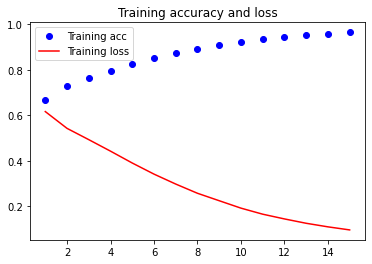

In [ ]:
plot_acc_loss_curves(history_word2vec)

The accuracy score for duplicate question detection using LSTM with word2vec is 0.734892

The precision score for duplicate question detection using LSTM with word2vec is 0.713201

The recall score for duplicate question detection using LSTM with word2vec is 0.788038

The f1 score for duplicate question detection using LSTM with word2vec is 0.748754

[[21651 10120]
 [ 6769 25166]]


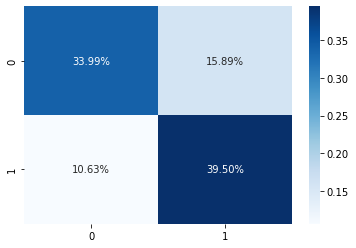

In [ ]:
print_metrics(y_valid.to_numpy(),y_pred,'LSTM with word2vec')

In [ ]:
from keras.utils.vis_utils import plot_model


plot_model(new_model_glove,show_layer_names=True,show_shapes=True)

In [ ]:
from keras.models import load_model
    
# new_model_glove.save('my_model_Glove.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
# new_model_word2vec.save('my_model_Word2Vec.h5') 

In [ ]:
#  model = load_model('my_model.h5')